### DIGITS 64d

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF

def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 

torch.manual_seed(990109)
np.random.seed(990109)

# Load digits data
digits = load_digits()
X = digits.images
y = digits.target

# Add Gaussian noise with variance 0.01
noise = scs.norm.rvs(0, 0.1, X.shape)
X_noisy = (X + noise)
X_noisy = (X_noisy - X_noisy.min()) / (X_noisy.max() - X_noisy.min()) # Normalize to [0, 1]

# Flatten the images for ECDF transformation
X_noisy_flat = X_noisy.reshape(-1, 64)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in range(64):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)

# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 8, 8)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)

# Convert to PyTorch tensors
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=42)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 8, 8)

    output:
        original_example: np.array - the original example, of shape (8, 8)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(8, 8) * 16
    
    return original_example


'''# Define the classifier for digits data (8x8 images)
class Classifier_Digits(nn.Module):
    def __init__(self, in_shape=(1, 8, 8)):
        super(Classifier_Digits, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 1)  # Adjusted for 8x8 input images
        )

    def forward(self, x):
        return self.model(x).exp()'''

# Define the classifier for digits data (8x8 images)
class Classifier_Digits(nn.Module):
    def __init__(self, in_shape=(1, 8, 8), normalising_cst=True, c=1.0):
        super(Classifier_Digits, self).__init__()
        self.normalising_cst = normalising_cst
        if self.normalising_cst:
            self.c = nn.Parameter(torch.tensor(c))

        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 1)  # Adjusted for 8x8 input images
        )

    def forward(self, x):
        logits = self.model(x).exp()
        if self.normalising_cst:
            logits = logits * self.c
        return logits
# Define model
model = Classifier_Digits()

# Print model summary
summary(model, (1, 8, 8))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]             640
         LeakyReLU-2             [-1, 64, 4, 4]               0
            Conv2d-3             [-1, 64, 2, 2]          36,928
         LeakyReLU-4             [-1, 64, 2, 2]               0
           Flatten-5                  [-1, 256]               0
            Linear-6                    [-1, 1]             257
Total params: 37,825
Trainable params: 37,825
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.14
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


In [53]:
from tqdm import tqdm
# Define loss function and optimizer
optimizer = optim.Adam(model.parameters())#, lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 501
for epoch in (range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        r_p = model(inputs).squeeze()  
        r_q = model(torch.randn((10*inputs.shape[0],1,8,8))).squeeze()      
        loss = loss_nce(r_p, r_q,inputs.shape[0], 10*inputs.shape[0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {model.c.item()}")


Epoch 10/501, Loss: 0.19363246883811622, c: 1.0280799865722656
Epoch 20/501, Loss: 0.10231255399512834, c: 1.0301003456115723
Epoch 30/501, Loss: 0.1186583954198607, c: 1.0294339656829834
Epoch 40/501, Loss: 0.04096487537026405, c: 1.0308198928833008
Epoch 50/501, Loss: 0.044914887696183445, c: 1.0304927825927734
Epoch 60/501, Loss: 0.03019460669622339, c: 1.0301027297973633
Epoch 70/501, Loss: 0.020447505691694897, c: 1.0289644002914429
Epoch 80/501, Loss: 0.01568047874125427, c: 1.0283764600753784
Epoch 90/501, Loss: 0.021564126598793244, c: 1.027772068977356
Epoch 100/501, Loss: 0.02885793684530152, c: 1.0261908769607544
Epoch 110/501, Loss: 0.0215142808718093, c: 1.025355339050293
Epoch 120/501, Loss: 0.015050560777910567, c: 1.022152066230774
Epoch 130/501, Loss: 0.015019956285962916, c: 1.0219917297363281
Epoch 140/501, Loss: 0.022484085584249535, c: 1.0208890438079834
Epoch 150/501, Loss: 0.028840023225398158, c: 1.020500659942627
Epoch 160/501, Loss: 0.015674364251277315, c: 1.

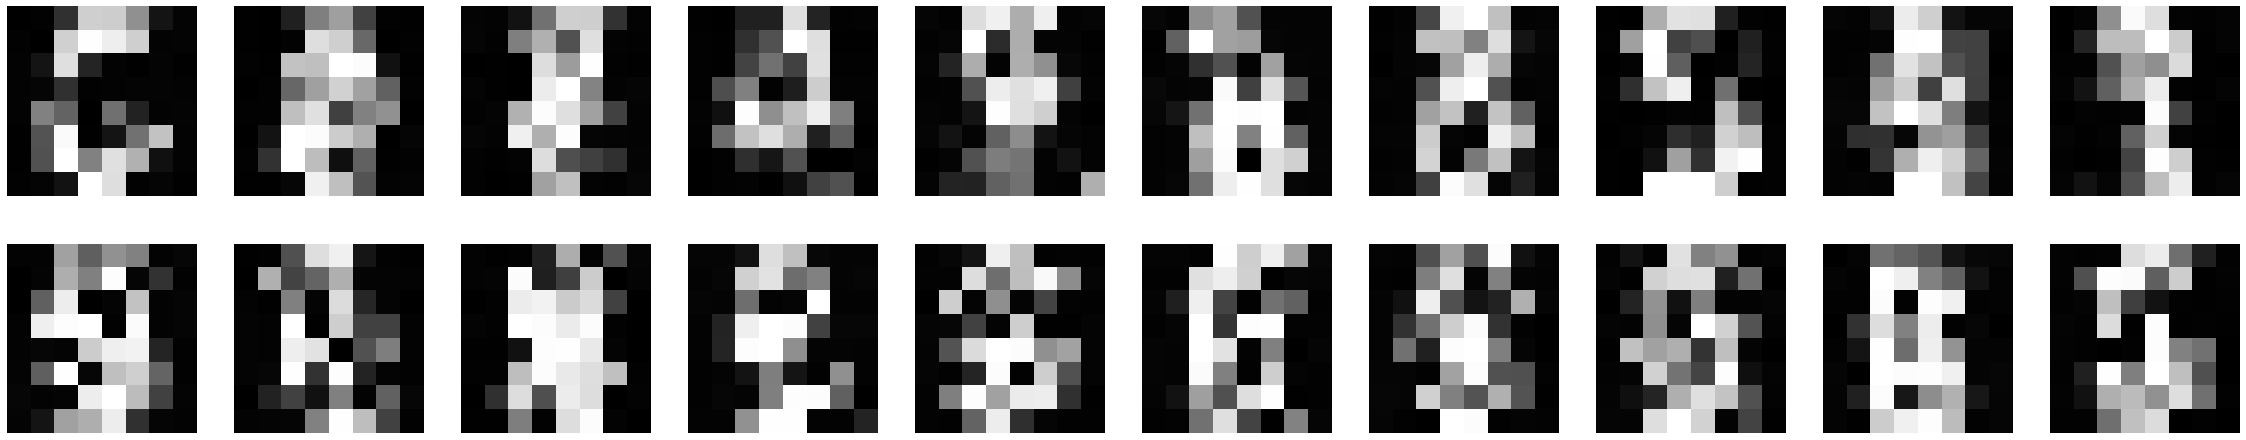

In [42]:
import matplotlib.pyplot as plt

noise_test = torch.randn(100000, 1, 8, 8)
r_noise = model(noise_test)
top_10_idx = np.argpartition(r_noise.detach().numpy().flatten(), -10)[-10:]
# Create a subplot of size 2x10
fig, axes = plt.subplots(2, 10, figsize=(40, 8))

# Plot the images corresponding to the largest 10 values in the first row
for i, idx in enumerate(top_10_idx):
    axes[0, i].matshow(reverse_transform(noise_test[idx].squeeze()), cmap='gray')
    axes[0, i].axis('off')
# Plot random images in the second row
for i, idx in enumerate(range(10)):
    axes[1, i].matshow(reverse_transform(noise_test[idx].squeeze()), cmap='gray')
    axes[1, i].axis('off')

plt.show()

In [81]:
noise_test[idx].squeeze().shape

torch.Size([8, 8])

In [73]:
# HMC

from pyhmc import hmc
import torch
import numpy as np

from tqdm import tqdm

def sample_hmc(ratio_model, num_samples, num_runs_hmc, num_burnin):
    ''' 
    Sample from the ratio model with HMC.
    
    args:
        ratio_model: nn.Module - the ratio model
        num_samples: int - the number of samples to generate per HMC run
        num_runs_hmc: int - the number of HMC runs, each giving num_samples draws
        num_burnin: int - the number of burn-in steps for a single HMC run
    
    returns:
        samples,log_pdf with
        samples: np.array - the generated samples of shape (num_runs_hmc*num_samples, 64)
        log_pdf: np.array - the log-pdf of the samples of shape (num_runs_hmc*num_samples,)
    '''

    def log_r_times_gauss(x):
        x_tensor = torch.tensor(x.reshape(1, 1, 8, 8), dtype=torch.float32, requires_grad=True)
        fun = torch.log(ratio_model(x_tensor)).sum() + torch.distributions.Normal(0, 1).log_prob(x_tensor).sum()
        fun.backward()
        grad_wrt_x = x_tensor.grad.reshape(1, -1)[0]
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

    samples = np.zeros((num_runs_hmc, num_samples, 64))
    log_pdf = np.zeros((num_runs_hmc, num_samples))
    x0_noise = np.zeros((num_runs_hmc, 8, 8))
    for hmc_run in tqdm( range(num_runs_hmc)):

        '''# pick x0 with highest r(x0) from random noise
        x0_proposal = torch.randn(1000, 1, 8, 8)
        r_noise = model(x0_proposal)
        x0_run = x0_proposal[np.argmax(r_noise.detach().numpy().flatten())]    
        '''
        # pick x0 randomly from N(0,1) 
        x0_run = torch.randn(1, 1, 8, 8)
        '''GG_cov = np.cov(X_train.reshape(-1,64).T)
        x0_run_np = scs.multivariate_normal.rvs(mean=np.zeros(64), cov=GG_cov, size=1).reshape(1,1,8,8)
        x0_run = torch.tensor(x0_run_np, dtype=torch.float32)'''
        samples_, log_pdf_ = hmc(log_r_times_gauss,
                            x0=x0_run.flatten().numpy(),
                            n_samples=num_samples,
                            return_logp=True,
                            n_burn=num_burnin)
        
        samples[hmc_run] = samples_
        log_pdf[hmc_run] = log_pdf_
        x0_noise[hmc_run] = x0_run

    return samples.reshape(-1,64), log_pdf.reshape(-1), x0_noise

samples, log_pdf, x0_noises = sample_hmc(ratio_model=model, 
                            num_samples=1, 
                            num_runs_hmc=500,
                            num_burnin=20)
samples.shape,log_pdf.shape,x0_noises.shape

100%|██████████| 500/500 [00:29<00:00, 17.16it/s]


((500, 64), (500,), (500, 8, 8))

In [106]:
def sample_ais(ratio_model, num_samples, num_burnin, num_burnin_ais, num_steps_ais):

    x0_samples = torch.randn(num_samples, 1, 8, 8)

    inverse_temperatures = np.linspace(0.0, 1.0, num_steps_ais)

    for beta in tqdm(inverse_temperatures):
        def tempered_log_fn(x):
            x_tensor = torch.tensor(x.reshape(1, 1, 8, 8), dtype=torch.float32, requires_grad=True)
            fun =   beta * (torch.log(ratio_model(x_tensor)).sum() + torch.distributions.Normal(0, 1).log_prob(x_tensor).sum()
                )+ (1-beta)*torch.distributions.Normal(0, 1).log_prob(x_tensor).sum()
            fun.backward()
            grad_wrt_x = x_tensor.grad.reshape(1, -1)[0]
            return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

        if beta == 1.0: # set burnin higher for the last step
            num_burnin = num_burnin_ais
        for i in range(num_samples):
            x0_sample = x0_samples[i].flatten().numpy()
            samples_ = hmc(tempered_log_fn,
                            x0=x0_sample,
                            n_samples=1,
                            return_logp=False,
                            n_burn=num_burnin)
            x0_samples[i] = torch.tensor(samples_[0].reshape(1, 1, 8, 8), dtype=torch.float32)

    return x0_samples.reshape(-1,64)

samples_ais = sample_ais(ratio_model=model,
            num_samples=25, 
            num_burnin=10,
            num_burnin_ais=50, 
            num_steps_ais=50)

100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


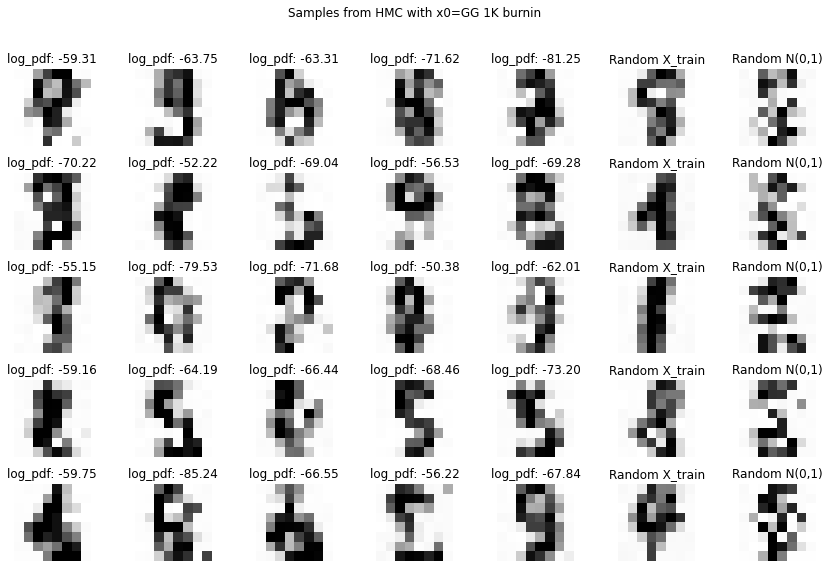

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create a figure and a set of subplots
fig, axes = plt.subplots(5, 7, figsize=(12, 8))
fig.suptitle('Samples from HMC with x0=GG 1K burnin')

# Loop through each row
for row in range(5):
    # Plot the samples in the first 5 columns
    for col in range(5):
        ax = axes[row, col]
        index = row * 5 + col
        img = reverse_transform(torch.tensor(samples[index]).reshape(8, 8)).reshape(8, 8)
        ax.imshow(img, cmap='gray_r')
        ax.axis('off')
        ax.set_title(f"log_pdf: {log_pdf[index]:.2f}")

    # Plot random samples of X_train in the 6th column
    ax = axes[row, 5]
    random_index = np.random.randint(len(X_train))
    img = reverse_transform(X_train[random_index]).reshape(8, 8)
    ax.imshow(img, cmap='gray_r')
    ax.axis('off')
    ax.set_title("Random X_train")

    # Plot random samples of N(0,1) in the 7th column
    ax = axes[row, 6]
    img = reverse_transform(torch.randn(1, 1, 8, 8)).reshape(8, 8)
    ax.imshow(img, cmap='gray_r')
    ax.axis('off')
    ax.set_title("Random N(0,1)")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make room for the suptitle
plt.show()

In [ ]:
model.c

Parameter containing:
tensor(1.0282, requires_grad=True)

In [13]:
def Energy_Score_pytorch(beta, observations_y, simulations_Y):
    m = len(simulations_Y)

    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
            simulations_Y.unsqueeze(0)).float(),
            dim=2,keepdim=True).reshape(-1,1),
        beta)

    # Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy
import ot

def W2(x,y):
    return torch.sqrt(ot.emd2(torch.ones(x.shape[0])/x.shape[0], torch.ones(y.shape[0])/y.shape[0], ot.dist(x, y)))

c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [ ]:
GG_cov = np.cov(X_train.reshape(-1,64).T)
GG_samples = scs.multivariate_normal.rvs(mean=np.zeros(64), cov=GG_cov, size=5000)

In [ ]:
top = scs.multivariate_normal(mean=np.zeros(64), cov=GG_cov).logpdf(X_test.reshape(-1,64))
bottom = scs.norm.logpdf(X_test.reshape(-1,64), loc=0, scale=1).sum(1)
(top-bottom).mean()

11.413952397743932

In [121]:
model(X_train).log().mean(),model(X_test).log().mean()

(tensor(17.4795, grad_fn=<MeanBackward0>),
 tensor(14.7282, grad_fn=<MeanBackward0>))

In [82]:
samples_ais.shape

torch.Size([25, 64])

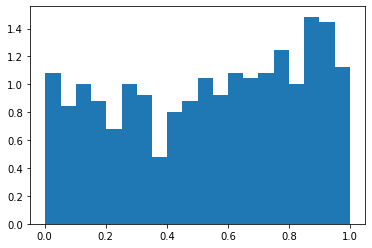

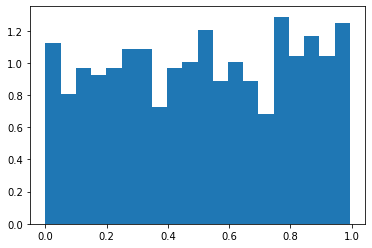

In [76]:
plt.hist(scs.norm.cdf(samples[:,0]),density=True, bins=20)
plt.show()
#plt.hist(scs.norm.cdf(samples_ais[:,0]),density=True, bins=20)
#plt.show()
plt.hist(scs.norm.cdf(GG_samples[:,0]),density=True, bins=20)
plt.show()

#### SR and W2 comparisons

In [47]:
import numpy as np
def check_bad_values(data_):
    # Check for NaN, inf or neginf values
    num_nan = np.isnan(data_).sum()
    num_pos_inf = np.isposinf(data_).sum()
    num_neg_inf = np.isneginf(data_).sum()
    if num_nan > 0 or num_pos_inf > 0 or num_neg_inf > 0:
        print(f"!!!!!!! Found {num_nan} NaN, {num_pos_inf} +Inf, and {num_neg_inf} -Inf values.")

In [ ]:
# Transform data to unit scale
def to_unit_scale(data):
    unit_data = scs.norm.cdf(data)
    unit_data = np.clip(unit_data, 1e-3, 1 - 1e-3)
    return unit_data

# Transform data back to data scale using ECDF
def to_data_scale(data, ecdf_list):
    data_scale = np.zeros_like(data)
    for dim in range(data.shape[1]):
        data_scale[:, dim] = np.interp(data[:, dim], np.linspace(0, 1, len(ecdf_list[dim].x)), ecdf_list[dim].x)
    data_scale = scs.norm.ppf(data_scale)
    check_bad_values(data_scale)
    return data_scale

# Transform samples
print('samples hmc')
samples_unit = to_unit_scale(samples)
samples_data = to_data_scale(samples_unit, ecdf_list)

print('samples ais')
samples_ais_unit = to_unit_scale(samples_ais)
samples_ais_data = to_data_scale(samples_ais_unit, ecdf_list)

print('random')
random_unit = to_unit_scale(torch.randn(500, 64).numpy())
random_data = to_data_scale(random_unit, ecdf_list)
print('GG')
GG_samples_unit = to_unit_scale(GG_samples)
GG_samples_data = to_data_scale(GG_samples_unit, ecdf_list)
print('vine')
vine_unit = to_unit_scale(scs.norm.ppf(cop_sample))
vine_data = to_data_scale(vine_unit, ecdf_list)
print('observations')
X_train_unit = to_unit_scale(X_train.reshape(-1, 64))
X_train_data = to_data_scale(X_train_unit, ecdf_list)
print('test')
X_test_unit = to_unit_scale(X_test.reshape(-1, 64))
X_test_data = torch.tensor(to_data_scale(X_test_unit, ecdf_list))

# Compute Energy Score
print('N01 start and 10 burnin data scale AIS-50')
print('Energy Score')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(samples_ais_data).float()), 'samples_ais')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(samples_data).float()), 'samples_hmc')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(random_data).float()), 'random')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(GG_samples_data).float()), 'GG')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(vine_data).float()), 'vine')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(X_train_data).float()), 'observations')

# Compute Wasserstein 2
print('Wasserstein 2')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(samples_ais_data).float()), 'ratio samples_ais')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(samples_data).float()), 'ratio samples_hmc')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(random_data).float()), 'random')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(GG_samples_data).float()), 'GG')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(vine_data).float()), 'vine')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(X_train_data).float()), 'observations')


#### Energy Score
print('N01 start and 10 burnin AIS-50 Gaussian scale')
print('Energy Score')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples_ais).float()),'samples_ais')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples_hmc')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(500,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

#### Wasserstein 2
print('Wasserstein 2')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples_ais).float(),),'ratio samples_ais')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples).float()),'ratio samples_hmc')
print(W2(X_test.reshape(-1,64).float(),torch.randn(500,64).float()),'random')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(GG_samples).float()),'GG')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(W2(X_test.reshape(-1,64).float(),X_train.reshape(-1,64).float()),'observations')

samples hmc
samples ais
random
GG
vine
observations
test
N01 start and 10 burnin data scale AIS-50
Energy Score
tensor(11.6530) samples_ais
tensor(11.1839) samples_hmc
tensor(11.1837) random
tensor(11.1144) GG
tensor(11.1271) vine
tensor(11.0911) observations
Wasserstein 2
tensor(13.3545) ratio samples_ais
tensor(13.2091) ratio samples_hmc
tensor(13.6097) random
tensor(12.8244) GG
tensor(13.1189) vine
tensor(12.0881) observations
N01 start and 10 burnin AIS-50 Gaussian scale
Energy Score
tensor(11.8127) samples_ais
tensor(11.3847) samples_hmc
tensor(11.2980) random


C:\Users\david\AppData\Local\Temp\ipykernel_27500\2437237769.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples_ais).float()),'samples_ais')


tensor(11.2747) GG
tensor(11.2768) vine
tensor(11.2698) observations
Wasserstein 2
tensor(9.5502) ratio samples_ais
tensor(8.8593) ratio samples_hmc


C:\Users\david\AppData\Local\Temp\ipykernel_27500\2437237769.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples_ais).float(),),'ratio samples_ais')


tensor(9.1901) random
tensor(8.1195) GG
tensor(8.5540) vine
tensor(7.4184) observations


In [97]:
# Transform data to unit scale
def to_unit_scale(data):
    unit_data = scs.norm.cdf(data)
    unit_data = np.clip(unit_data, 1e-3, 1 - 1e-3)
    return unit_data

# Transform data back to data scale using ECDF
def to_data_scale(data, ecdf_list):
    data_scale = np.zeros_like(data)
    for dim in range(data.shape[1]):
        data_scale[:, dim] = np.interp(data[:, dim], np.linspace(0, 1, len(ecdf_list[dim].x)), ecdf_list[dim].x)
    data_scale = scs.norm.ppf(data_scale)
    check_bad_values(data_scale)
    return data_scale

# Transform samples
print('samples')
samples_unit = to_unit_scale(samples_ais)
samples_data = to_data_scale(samples_unit, ecdf_list)

print('random')
random_unit = to_unit_scale(torch.randn(500, 64).numpy())
random_data = to_data_scale(random_unit, ecdf_list)
print('GG')
GG_samples_unit = to_unit_scale(GG_samples)
GG_samples_data = to_data_scale(GG_samples_unit, ecdf_list)
print('vine')
vine_unit = to_unit_scale(scs.norm.ppf(cop_sample))
vine_data = to_data_scale(vine_unit, ecdf_list)
print('observations')
X_train_unit = to_unit_scale(X_train.reshape(-1, 64))
X_train_data = to_data_scale(X_train_unit, ecdf_list)
print('test')
X_test_unit = to_unit_scale(X_test.reshape(-1, 64))
X_test_data = torch.tensor(to_data_scale(X_test_unit, ecdf_list))

# Compute Energy Score
print('N01 start and 50 burnin data scale AIS-7')
print('Energy Score')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(samples_data).float()), 'samples_ais')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(random_data).float()), 'random')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(GG_samples_data).float()), 'GG')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(vine_data).float()), 'vine')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(X_train_data).float()), 'observations')

# Compute Wasserstein 2
print('Wasserstein 2')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(samples_data).float()), 'ratio samples_ais')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(random_data).float()), 'random')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(GG_samples_data).float()), 'GG')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(vine_data).float()), 'vine')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(X_train_data).float()), 'observations')


#### Energy Score
print('N01 start and 50 burnin AIS-7')
print('Energy Score')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples_ais).float()),'samples_ais')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(500,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

#### Wasserstein 2
print('Wasserstein 2')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples_ais).float(),),'ratio samples_ais')
print(W2(X_test.reshape(-1,64).float(),torch.randn(500,64).float()),'random')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(GG_samples).float()),'GG')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(W2(X_test.reshape(-1,64).float(),X_train.reshape(-1,64).float()),'observations')

samples
random
GG
vine
observations
test
N01 start and 50 burnin data scale AIS-7
Energy Score
tensor(11.2030) samples_ais
tensor(11.1829) random
tensor(11.1144) GG
tensor(11.1271) vine
tensor(11.0911) observations
Wasserstein 2
tensor(13.2950) ratio samples_ais
tensor(13.6045) random
tensor(12.8244) GG
tensor(13.1189) vine
tensor(12.0881) observations
N01 start and 50 burnin AIS-7
Energy Score
tensor(11.3548) samples_ais
tensor(11.3001) random


C:\Users\david\AppData\Local\Temp\ipykernel_27500\4079260195.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples_ais).float()),'samples_ais')


tensor(11.2747) GG
tensor(11.2768) vine
tensor(11.2698) observations
Wasserstein 2
tensor(8.8629) ratio samples_ais


C:\Users\david\AppData\Local\Temp\ipykernel_27500\4079260195.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples_ais).float(),),'ratio samples_ais')


tensor(9.1441) random
tensor(8.1195) GG
tensor(8.5540) vine
tensor(7.4184) observations


In [57]:
# Transform data to unit scale
def to_unit_scale(data):
    unit_data = scs.norm.cdf(data)
    unit_data = np.clip(unit_data, 1e-3, 1 - 1e-3)
    return unit_data

# Transform data back to data scale using ECDF
def to_data_scale(data, ecdf_list):
    data_scale = np.zeros_like(data)
    for dim in range(data.shape[1]):
        data_scale[:, dim] = np.interp(data[:, dim], np.linspace(0, 1, len(ecdf_list[dim].x)), ecdf_list[dim].x)
    data_scale = scs.norm.ppf(data_scale)
    check_bad_values(data_scale)
    return data_scale

# Transform samples
print('samples')
samples_unit = to_unit_scale(samples)
samples_data = to_data_scale(samples_unit, ecdf_list)

print('random')
random_unit = to_unit_scale(torch.randn(500, 64).numpy())
random_data = to_data_scale(random_unit, ecdf_list)
print('GG')
GG_samples_unit = to_unit_scale(GG_samples)
GG_samples_data = to_data_scale(GG_samples_unit, ecdf_list)
print('vine')
vine_unit = to_unit_scale(scs.norm.ppf(cop_sample))
vine_data = to_data_scale(vine_unit, ecdf_list)
print('observations')
X_train_unit = to_unit_scale(X_train.reshape(-1, 64))
X_train_data = to_data_scale(X_train_unit, ecdf_list)
print('test')
X_test_unit = to_unit_scale(X_test.reshape(-1, 64))
X_test_data = torch.tensor(to_data_scale(X_test_unit, ecdf_list))

# Compute Energy Score
print('N01 start and 50 burnin data scale')
print('Energy Score')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(samples_data).float()), 'samples')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(random_data).float()), 'random')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(GG_samples_data).float()), 'GG')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(vine_data).float()), 'vine')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(X_train_data).float()), 'observations')

# Compute Wasserstein 2
print('Wasserstein 2')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(samples_data).float()), 'ratio samples')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(random_data).float()), 'random')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(GG_samples_data).float()), 'GG')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(vine_data).float()), 'vine')
print(W2(X_test.reshape(-1, 64).float(), torch.tensor(X_train_data).float()), 'observations')

samples
random
GG
vine
observations
test
N01 start and 50 burnin data scale
Energy Score
tensor(11.1839) samples
tensor(11.1847) random
tensor(11.1112) GG
tensor(11.1271) vine
tensor(11.0911) observations
Wasserstein 2
tensor(13.2091) ratio samples
tensor(13.6332) random
tensor(12.8331) GG
tensor(13.1189) vine
tensor(12.0881) observations


In [56]:
#### Energy Score
print('N01 start and 50 burnin')
print('Energy Score')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(500,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

#### Wasserstein 2
print('Wasserstein 2')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples).float(),),'ratio samples')
print(W2(X_test.reshape(-1,64).float(),torch.randn(500,64).float()),'random')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(GG_samples).float()),'GG')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(W2(X_test.reshape(-1,64).float(),X_train.reshape(-1,64).float()),'observations')

N01 start and 50 burnin
Energy Score
tensor(11.3847) samples
tensor(11.3002) random
tensor(11.2724) GG
tensor(11.2768) vine
tensor(11.2698) observations
Wasserstein 2
tensor(8.8593) ratio samples
tensor(9.1535) random
tensor(8.1200) GG
tensor(8.5540) vine
tensor(7.4184) observations


In [250]:
#### Energy Score
print('N01 start and 20 burnin')
print('Energy Score')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

#### Wasserstein 2
print('Wasserstein 2')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples).float(),),'ratio samples')
print(W2(X_test.reshape(-1,64).float(),torch.randn(5000,64).float()),'random')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(GG_samples).float()),'GG')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(W2(X_test.reshape(-1,64).float(),X_train.reshape(-1,64).float()),'observations')

N01 start and 20 burnin
Energy Score
tensor(11.3303) samples
tensor(11.2897) random
tensor(11.2621) GG
tensor(11.2623) vine
tensor(11.2596) observations
Wasserstein 2
tensor(8.3561) ratio samples
tensor(9.0065) random
tensor(8.1130) GG
tensor(8.4209) vine
tensor(7.3906) observations


In [244]:
#### Energy Score
print('GG start and 50 burnin')
print('Energy Score')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

#### Wasserstein 2
print('Wasserstein 2')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples).float(),),'ratio samples')
print(W2(X_test.reshape(-1,64).float(),torch.randn(5000,64).float()),'random')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(GG_samples).float()),'GG')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(W2(X_test.reshape(-1,64).float(),X_train.reshape(-1,64).float()),'observations')

GG start and 50 burnin
Energy Score
tensor(11.5173) samples
tensor(11.2895) random
tensor(11.2621) GG
tensor(11.2623) vine
tensor(11.2596) observations
Wasserstein 2
tensor(8.7845) ratio samples
tensor(8.9931) random
tensor(8.1130) GG
tensor(8.4209) vine
tensor(7.3906) observations


In [238]:
#### Energy Score
print('GG start and 10 burnin')

print('Energy Score')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

#### Wasserstein 2
print('Wasserstein 2')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples).float(),),'ratio samples')
print(W2(X_test.reshape(-1,64).float(),torch.randn(5000,64).float()),'random')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(GG_samples).float()),'GG')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(W2(X_test.reshape(-1,64).float(),X_train.reshape(-1,64).float()),'observations')

tensor(11.2759) samples
tensor(11.2887) random
tensor(11.2621) GG
tensor(11.2623) vine
tensor(11.2596) observations
tensor(8.2515) ratio samples
tensor(9.0025) random
tensor(8.1130) GG
tensor(8.4209) vine
tensor(7.3906) observations


In [218]:
#### Energy Score (10 steps after GG)
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

tensor(11.2858) samples
tensor(11.2890) random
tensor(11.2621) GG
tensor(11.2623) vine
tensor(11.2596) observations


In [217]:
#### Wasserstein 2 (10 steps after GG)
print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples).float(),),'ratio samples')
print(W2(X_test.reshape(-1,64).float(),torch.randn(5000,64).float()),'random')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(GG_samples).float()),'GG')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(W2(X_test.reshape(-1,64).float(),X_train.reshape(-1,64).float()),'observations')

tensor(8.2756) ratio samples
tensor(9.0207) random
tensor(8.1130) GG
tensor(8.4209) vine
tensor(7.3906) observations


In [58]:
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

tensor(12.9443) samples
tensor(11.2621) GG
tensor(11.2892) random
tensor(11.2596) observations


In [322]:
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

tensor(11.4530) samples
tensor(11.2422) GG
tensor(11.2690) random
tensor(11.2403) observations


In [247]:
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

tensor(11.2689) samples
tensor(11.2675) GG
tensor(11.2947) random
tensor(11.2676) observations


### Simple Ratio

In [258]:
class Ratio_Simple(nn.Module):
    def __init__(self, in_shape=(1, 8, 8), normalising_cst=True, c=1.0):
        super(Ratio_Simple, self).__init__()
        self.normalising_cst = normalising_cst
        if self.normalising_cst:
            self.c = nn.Parameter(torch.tensor(c))

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_shape[0] * in_shape[1] * in_shape[2], 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        logits = self.model(x).exp()
        if self.normalising_cst:
            logits = logits * self.c
        return logits


# Define model
ratio_model = Ratio_Simple()

# Print model summary
summary(ratio_model, (1, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [-1, 64]               0
            Linear-2                  [-1, 100]           6,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                    [-1, 1]             101
Total params: 16,701
Trainable params: 16,701
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [259]:
# training loop for GG Ratio

# Define loss function and optimizer
optimizer = optim.Adam(ratio_model.parameters())#, lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 501

GG_cov = np.cov(X_train.reshape(-1,64).T)
GG_noise = torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(64), cov=GG_cov, size=10*X_train.shape[0]).reshape(-1,1,8,8)).float()

for epoch in (range(num_epochs)):
    ratio_model.train()
    running_loss = 0.0
    noise_index = 0 
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        r_p = ratio_model(inputs).squeeze()
        r_q = ratio_model(torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(64), cov=GG_cov, size=10*inputs.shape[0]).reshape(-1,1,8,8)).float()).squeeze()
        noise_index += inputs.shape[0]
        loss = loss_nce(r_p, r_q,inputs.shape[0], 10*inputs.shape[0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {ratio_model.c.item()}")

Epoch 10/501, Loss: 2.244431635429119, c: 1.0016618967056274
Epoch 20/501, Loss: 1.109693496391691, c: 1.0144317150115967
Epoch 30/501, Loss: 0.70937402906089, c: 1.0083423852920532
Epoch 40/501, Loss: 0.48105793471994074, c: 1.0058248043060303
Epoch 50/501, Loss: 0.378987898343596, c: 1.0021138191223145
Epoch 60/501, Loss: 0.26448320263418656, c: 0.9986446499824524
Epoch 70/501, Loss: 0.2578981464792942, c: 0.996145486831665
Epoch 80/501, Loss: 0.16404327930047594, c: 0.994384765625
Epoch 90/501, Loss: 0.15903485874677525, c: 0.9921455979347229
Epoch 100/501, Loss: 0.13853582033309444, c: 0.9912807941436768
Epoch 110/501, Loss: 0.16287757803140016, c: 0.9895222187042236
Epoch 120/501, Loss: 0.10169736944652837, c: 0.9869585037231445
Epoch 130/501, Loss: 0.11432863553536349, c: 0.9849940538406372
Epoch 140/501, Loss: 0.10356004433385257, c: 0.9861159920692444
Epoch 150/501, Loss: 0.10508841886345682, c: 0.9822591543197632
Epoch 160/501, Loss: 0.11192089126541696, c: 0.9803228378295898


In [281]:
model_GG_CNN = Classifier_Digits()
# training loop for GG Ratio

# Define loss function and optimizer
optimizer = optim.Adam(model_GG_CNN.parameters())#, lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 501

GG_cov = np.cov(X_train.reshape(-1,64).T)
GG_noise = torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(64), cov=GG_cov, size=10*X_train.shape[0]).reshape(-1,1,8,8)).float()

for epoch in (range(num_epochs)):
    model_GG_CNN.train()
    running_loss = 0.0
    noise_index = 0 
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        r_p = model_GG_CNN(inputs).squeeze()
        r_q = model_GG_CNN(torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(64), cov=GG_cov, size=10*inputs.shape[0]).reshape(-1,1,8,8)).float()).squeeze()
        noise_index += inputs.shape[0]
        loss = loss_nce(r_p, r_q,inputs.shape[0], 10*inputs.shape[0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {model_GG_CNN.c.item()}")

Epoch 10/501, Loss: 2.5732232085589706, c: 1.0086371898651123
Epoch 20/501, Loss: 1.3594865017923816, c: 1.0129189491271973
Epoch 30/501, Loss: 0.919487529787524, c: 1.0156917572021484
Epoch 40/501, Loss: 0.6556198864147581, c: 1.0167620182037354
Epoch 50/501, Loss: 0.4055976980719073, c: 1.018160104751587
Epoch 60/501, Loss: 0.35684987388808154, c: 1.0179154872894287
Epoch 70/501, Loss: 0.2463508551490718, c: 1.0175544023513794
Epoch 80/501, Loss: 0.32911794786823206, c: 1.0171229839324951
Epoch 90/501, Loss: 0.25760068384737805, c: 1.017835021018982
Epoch 100/501, Loss: 0.1694863811135292, c: 1.0174072980880737
Epoch 110/501, Loss: 0.1416092574082572, c: 1.0171546936035156
Epoch 120/501, Loss: 0.10750320836387832, c: 1.0171000957489014
Epoch 130/501, Loss: 0.2011736906294165, c: 1.016190767288208
Epoch 140/501, Loss: 0.09932413363251193, c: 1.0172215700149536
Epoch 150/501, Loss: 0.10525948470779534, c: 1.0176230669021606
Epoch 160/501, Loss: 0.16195876196283718, c: 1.017638444900512

In [282]:
# GG_CNN_Ratio

# Compute GG ratio alone
gg_CNN_ratio_train = model_GG_CNN(X_train).log().mean()
gg_CNN_ratio_test = model_GG_CNN(X_test).log().mean()

# Compute GG ratio corrected
gg_CNN_ratio_corrected_train = (GG_correction_train + model_GG_CNN(X_train).log()).mean()
gg_CNN_ratio_corrected_test = (GG_correction_test + model_GG_CNN(X_test).log()).mean()

# Print the results
print('GG CNN ratio alone', gg_CNN_ratio_train.item(), gg_CNN_ratio_test.item())
print('GG CNN ratio corrected ; GG_ratio full', gg_CNN_ratio_corrected_train.item(), gg_CNN_ratio_corrected_test.item())

GG CNN ratio alone 9.132304191589355 0.886150598526001
GG CNN ratio corrected ; GG_ratio full 23.5766544342041 12.551363945007324


In [266]:
import torch.distributions as dist
ratio_model.eval()
X_train_flat = X_train.reshape(-1, 64)
X_test_flat = X_test.reshape(-1, 64)
# Define the multivariate normal distribution with the given covariance matrix
GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(64), covariance_matrix=GG_cov_tensor)
# Define the standard normal distribution
standard_normal = dist.Normal(loc=0, scale=1)
# Compute logpdf for the multivariate normal distribution
logpdf_multivariate_train = multivariate_normal.log_prob(X_train_flat)
logpdf_multivariate_test = multivariate_normal.log_prob(X_test_flat)
# Compute logpdf for the standard normal distribution and sum over the dimensions
logpdf_standard_train = standard_normal.log_prob(X_train_flat).sum(dim=1)
logpdf_standard_test = standard_normal.log_prob(X_test_flat).sum(dim=1)
# Compute GG_correction
GG_correction_train = logpdf_multivariate_train - logpdf_standard_train
GG_correction_test = logpdf_multivariate_test - logpdf_standard_test
# Compute means
mean_GG_correction_train = GG_correction_train.mean()
mean_GG_correction_test = GG_correction_test.mean()

# Compute GG ratio alone
gg_ratio_train = ratio_model(X_train).log().mean()
gg_ratio_test = ratio_model(X_test).log().mean()

# Compute GG ratio corrected
gg_ratio_corrected_train = (GG_correction_train + ratio_model(X_train).log()).mean()
gg_ratio_corrected_test = (GG_correction_test + ratio_model(X_test).log()).mean()

# Print the results
print('GG ratio alone', gg_ratio_train.item(), gg_ratio_test.item())
print('GG ratio corrected ; GG_ratio full', gg_ratio_corrected_train.item(), gg_ratio_corrected_test.item())

GG ratio alone 9.308335304260254 -4.693418502807617
GG ratio corrected ; GG_ratio full 23.752681732177734 6.971794128417969


In [239]:
def log_GGratio_gauss(x):

    x_tensor = torch.tensor(x.reshape(1, 1, 8, 8), dtype=torch.float32, requires_grad=True)
    x_flat = x_tensor.reshape(-1, 64)
    # define N(Sigma) and N(0,1), then compute on x
    GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
    multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(64), covariance_matrix=GG_cov_tensor)
    standard_normal = dist.Normal(loc=0, scale=1)
    logpdf_multivariate = multivariate_normal.log_prob(x_flat)
    logpdf_standard = standard_normal.log_prob(x_flat).sum(dim=1)
    gg_correction = logpdf_multivariate - logpdf_standard
    # Compute the log of the ratio model
    log_ratio = torch.log(ratio_model(x_tensor)).sum()
    # Compute the log probability of x under the standard normal distribution
    log_prob_standard = standard_normal.log_prob(x_tensor).sum()
    # Compute the final function value
    fun = log_ratio + gg_correction + log_prob_standard
    # Backward pass to compute the gradient
    fun.backward()
    grad_wrt_x = x_tensor.grad.reshape(1, -1)[0]
    
    return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

log_GGratio_gauss(X_train[0].numpy())

(array(-108.31665039),
 array([-1.65390551,  3.51264262,  0.31878144, -0.32775736,  0.32050765,
         1.27710867, -0.58677059, -0.37025207,  0.04170698, -2.05952358,
        -0.2685622 ,  2.91791582, -1.03790593, -4.12060452,  1.70337403,
        -0.02391607, -0.87640452, -1.40498686, -0.02932864, -1.74485052,
         1.2907362 ,  1.8873111 , -2.38607216, -1.88214684,  0.79137659,
         1.3374505 , -0.44994396,  2.10135531, -1.09536636,  1.59071195,
        -2.6909709 , -3.40343952, -2.21118569,  1.49575388, -4.32536411,
         1.23560727,  1.14836872,  2.67073059, -3.66837549, -0.82111669,
        -1.62356234, -1.94162142,  3.70280099,  2.17116189,  3.08886886,
        -0.71690273,  1.18300152, -2.04800487, -2.39376044, -4.01386309,
        -3.57837439, -2.47166252, -1.1624999 ,  0.48416591,  1.56811404,
         0.03077218,  0.42341936,  2.25831151,  0.77050841,  1.1898737 ,
        -0.31064945,  1.08196485,  0.47885764, -1.20591688]))

In [283]:
# HMC

from pyhmc import hmc
import torch
import numpy as np

from tqdm import tqdm

def sample_GG_hmc(GG_ratio_model, num_samples, num_runs_hmc, num_burnin):
    ''' 
    Sample from the ratio model with HMC.
    
    args:
        GG_ratio_model: nn.Module - the GG ratio copula model
        num_samples: int - the number of samples to generate per HMC run
        num_runs_hmc: int - the number of HMC runs, each giving num_samples draws
        num_burnin: int - the number of burn-in steps for a single HMC run
    
    returns:
        samples,log_pdf with
        samples: np.array - the generated samples of shape (num_runs_hmc*num_samples, 64)
        log_pdf: np.array - the log-pdf of the samples of shape (num_runs_hmc*num_samples,)
    '''
    GG_ratio_model.eval()
    def log_GGratio_gauss(x):
        # compute the top part of a GG_ratio copula logpdf and the gradients of that
        x_tensor = torch.tensor(x.reshape(1, 1, 8, 8), dtype=torch.float32, requires_grad=True)
        x_flat = x_tensor.reshape(-1, 64)
        # define N(Sigma) and N(0,1), then compute on x
        GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
        multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(64), covariance_matrix=GG_cov_tensor)
        standard_normal = dist.Normal(loc=0, scale=1)
        logpdf_multivariate = multivariate_normal.log_prob(x_flat)
        logpdf_standard = standard_normal.log_prob(x_flat).sum(dim=1)
        gg_correction = logpdf_multivariate - logpdf_standard
        # Compute the log of the ratio model
        log_ratio = torch.log(GG_ratio_model(x_tensor)).sum()
        # Compute the log probability of x under the standard normal distribution
        log_prob_standard = standard_normal.log_prob(x_tensor).sum()
        # Compute the final function value
        fun = log_ratio + gg_correction + log_prob_standard
        # Backward pass to compute the gradient
        fun.backward()
        grad_wrt_x = x_tensor.grad.reshape(1, -1)[0]
        
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

    samples = np.zeros((num_runs_hmc, num_samples, 64))
    log_pdf = np.zeros((num_runs_hmc, num_samples))
    x0_noise = np.zeros((num_runs_hmc, 8, 8))
    for hmc_run in tqdm( range(num_runs_hmc)):

        '''# pick x0 with highest r(x0) from random noise
        x0_proposal = torch.randn(1000, 1, 8, 8)
        r_noise = model(x0_proposal)
        x0_run = x0_proposal[np.argmax(r_noise.detach().numpy().flatten())]    
        '''
        # pick x0 randomly from N(0,1) 
        x0_run = torch.randn(1, 1, 8, 8)
        '''GG_cov = np.cov(X_train.reshape(-1,64).T)
        x0_run_np = scs.multivariate_normal.rvs(mean=np.zeros(64), cov=GG_cov, size=1).reshape(1,1,8,8)
        x0_run = torch.tensor(x0_run_np, dtype=torch.float32)'''
        samples_, log_pdf_ = hmc(log_GGratio_gauss,
                            x0=x0_run.flatten().numpy(),
                            n_samples=num_samples,
                            return_logp=True,
                            n_burn=num_burnin)
        
        samples[hmc_run] = samples_
        log_pdf[hmc_run] = log_pdf_
        x0_noise[hmc_run] = x0_run

    return samples.reshape(-1,64), log_pdf.reshape(-1), x0_noise

samples_simple, log_pdf, x0_noises = sample_GG_hmc(GG_ratio_model=model_GG_CNN, 
                            num_samples=1, 
                            num_runs_hmc=500,
                            num_burnin=100)
samples_simple.shape,log_pdf.shape,x0_noises.shape

100%|██████████| 500/500 [04:16<00:00,  1.95it/s]


((500, 64), (500,), (500, 8, 8))

In [262]:
ratio_model.c

Parameter containing:
tensor(0.9526, requires_grad=True)

In [287]:
ratio_model(X_test).log().mean()

tensor(-4.6934, grad_fn=<MeanBackward0>)

In [288]:
ratio_model(torch.tensor(samples_simple.reshape(-1,1,8,8)).float()).log().mean()

tensor(-6.0537, grad_fn=<MeanBackward0>)

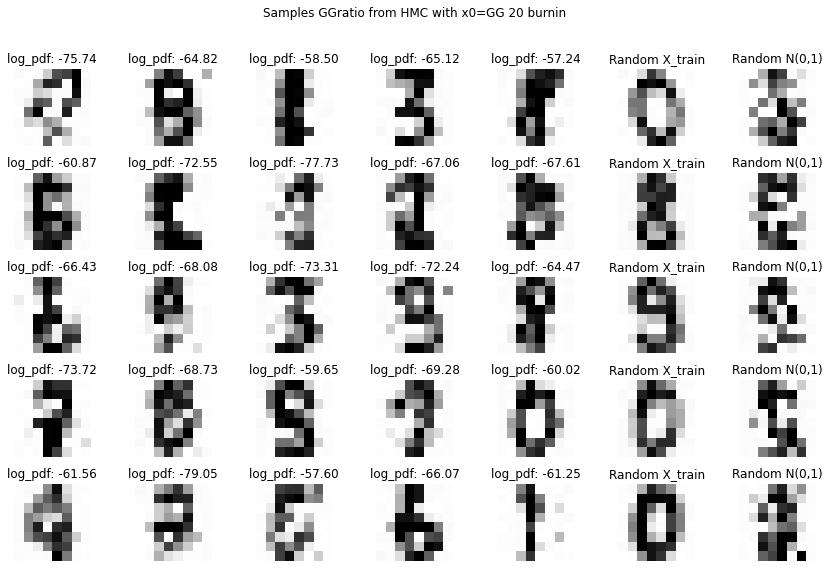

In [289]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create a figure and a set of subplots
fig, axes = plt.subplots(5, 7, figsize=(12, 8))
fig.suptitle('Samples GGratio from HMC with x0=GG 20 burnin')

# Loop through each row
for row in range(5):
    # Plot the samples in the first 5 columns
    for col in range(5):
        ax = axes[row, col]
        index = row * 5 + col
        img = reverse_transform(torch.tensor(samples_simple[index]).reshape(8, 8)).reshape(8, 8)
        ax.imshow(img, cmap='gray_r')
        ax.axis('off')
        ax.set_title(f"log_pdf: {log_pdf[index]:.2f}")

    # Plot random samples of X_train in the 6th column
    ax = axes[row, 5]
    random_index = np.random.randint(len(X_train))
    img = reverse_transform(X_train[random_index]).reshape(8, 8)
    ax.imshow(img, cmap='gray_r')
    ax.axis('off')
    ax.set_title("Random X_train")

    # Plot random samples of N(0,1) in the 7th column
    ax = axes[row, 6]
    img = reverse_transform(torch.randn(1, 1, 8, 8)).reshape(8, 8)
    ax.imshow(img, cmap='gray_r')
    ax.axis('off')
    ax.set_title("Random N(0,1)")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make room for the suptitle
plt.show()

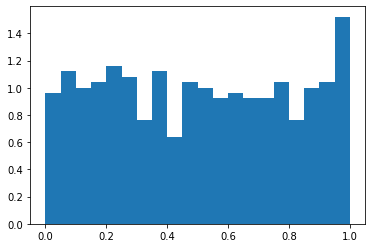

In [290]:
plt.hist(scs.norm.cdf(samples_simple[:,0]),density=True, bins=20)
plt.show()

### Vine on Digits

In [49]:
import pyvinecopulib as pv
import time 

# map X_train to copula scale
U = scs.norm.cdf(X_train.reshape(-1,64))

start = time.time()
controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.tll],
                                                selection_criterion='mbic',
                                                nonparametric_method='constant', #KDE-copula
                                                nonparametric_mult=10) # bandwidth
cop = pv.Vinecop(U, controls=controls)
print('fitted',time.time()-start)

fitted 217.26954007148743


In [50]:
time2 = time.time()
cop_sample = cop.simulate(500)
print('sims', time.time()-time2)

sims 46.63482689857483


In [107]:
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(scs.norm.ppf(cop_sample))),'vinecop')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

tensor(11.3847) samples
tensor(11.2747) GG
tensor(11.3000) random
tensor(11.2768, dtype=torch.float64) vinecop
tensor(11.2698) observations


In [153]:
X_test_cop01 = torch.tensor(scs.norm.cdf(X_test))
print(Energy_Score_pytorch(1,X_test_cop01.reshape(-1,64),torch.tensor(scs.norm.cdf(samples)).float()),'samples')
print(Energy_Score_pytorch(1,X_test_cop01.reshape(-1,64),torch.tensor(scs.norm.cdf(GG_samples)).float()),'GG')
print(Energy_Score_pytorch(1,X_test_cop01.reshape(-1,64),torch.tensor(scs.norm.cdf(torch.randn(5000,64))).float()),'random')
print(Energy_Score_pytorch(1,X_test_cop01.reshape(-1,64),torch.tensor(cop_sample)),'vinecop')
print(Energy_Score_pytorch(1,X_test_cop01.reshape(-1,64),torch.tensor(scs.norm.cdf(X_train)).reshape(-1,64)),'observations')

tensor(3.5504) samples
tensor(3.2492) GG
tensor(3.2585) random
tensor(3.2494, dtype=torch.float64) vinecop
tensor(3.2483, dtype=torch.float64) observations


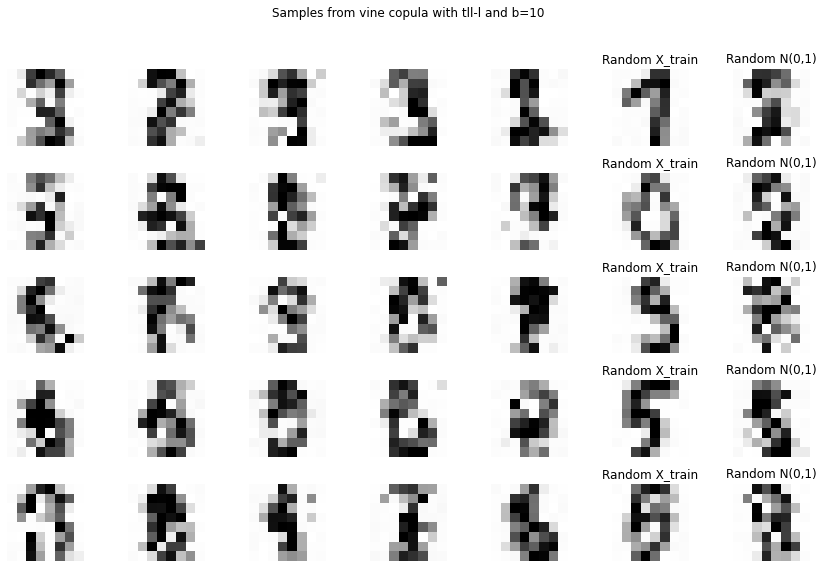

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create a figure and a set of subplots
fig, axes = plt.subplots(5, 7, figsize=(12, 8))
fig.suptitle('Samples from vine copula with tll-l and b=10')

# Loop through each row
for row in range(5):
    # Plot the samples in the first 5 columns
    for col in range(5):
        ax = axes[row, col]
        index = row * 5 + col
        img = reverse_transform(torch.tensor(scs.norm.ppf(cop_sample[index])).reshape(8, 8)).reshape(8, 8)
        ax.imshow(img, cmap='gray_r')
        ax.axis('off')
        #ax.set_title(f"log_pdf: {log_pdf[index]:.2f}")

    # Plot random samples of X_train in the 6th column
    ax = axes[row, 5]
    random_index = np.random.randint(len(X_train))
    img = reverse_transform(X_train[random_index]).reshape(8, 8)
    ax.imshow(img, cmap='gray_r')
    ax.axis('off')
    ax.set_title("Random X_train")

    # Plot random samples of N(0,1) in the 7th column
    ax = axes[row, 6]
    img = reverse_transform(torch.randn(1, 1, 8, 8)).reshape(8, 8)
    ax.imshow(img, cmap='gray_r')
    ax.axis('off')
    ax.set_title("Random N(0,1)")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make room for the suptitle
plt.show()

In [55]:
model(X_test.float()).log().mean()

tensor(12.7969, grad_fn=<MeanBackward0>)

In [59]:
time3 = time.time()
vine_ll = cop.loglik(scs.norm.cdf(X_test.detach().numpy().reshape(-1,64)))
print('ll',vine_ll/X_test.shape[0],'time',time.time()-time3)

ll 11.510539092639913 time 4.415481328964233


### ICG copula

In [267]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as scs
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF


class SoftRank(nn.Module):
    """Differentiable ranking layer"""
    def __init__(self, alpha=1000.0):
        super(SoftRank, self).__init__()
        self.alpha = alpha # constant for scaling the sigmoid to approximate sign function, larger values ensure better ranking, overflow is handled properly by PyTorch

    def forward(self, inputs):
        # input is a ?xSxD tensor, we wish to rank the S samples in each dimension per each batch
        # output is  ?xSxD tensor where for each dimension the entries are (rank-0.5)/N_rank
        x = inputs.unsqueeze(-1) #(?,S,D) -> (?,S,D,1)
        x_2 = x.repeat(1, 1, 1, x.shape[1]) # (?,S,D,1) -> (?,S,D,S) (samples are repeated along axis 3, i.e. the last axis)
        x_1 = x_2.transpose(1, 3) #  (?,S,D,S) -> (?,S,D,S) (samples are repeated along axis 1)
        return torch.transpose(torch.sum(torch.sigmoid(self.alpha*(x_1-x_2)), dim=1), 1, 2)/(torch.tensor(x.shape[1], dtype=torch.float32))


class IGC(nn.Module):
    
    def __init__(self, hidden_size=100, layers_number=2, output_size=2):
        super(IGC, self).__init__()
        self.dim_latent = 3 * output_size
        self.hidden_size = hidden_size
        self.layers_nuber = layers_number
        self.output_size = output_size
        self.linear_in = nn.Linear(in_features=self.dim_latent, out_features=self.hidden_size) 
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.linear_out = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)
        self.marginal_cdfs = None
        self.ecdf_10e6_samples = None

    def forward_train(self, z):
        '''
        Input noise z with shape (M,dim_latent)\\
        Outputs (u,v) pairs with shape (M,output_size=2), while ensuring u and v each have uniform marginals.
        '''
        y = torch.relu(self.linear_in(z))
        for layer in range(self.layers_nuber):
            y = torch.relu(self.linear(y))
        y = self.linear_out(y).unsqueeze(0)
        u = SoftRank()(y).squeeze(0)
        return u
        
    def Energy_Score_pytorch(self,beta, observations_y, simulations_Y):
        n = len(observations_y)
        m = len(simulations_Y)

        # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
        diff_Y_y = torch.pow(
            torch.norm(
                (observations_y.unsqueeze(1) -
                simulations_Y.unsqueeze(0)).float(),
                dim=2,keepdim=True).reshape(-1,1),
            beta)

        # Second part |Y-Y'|. 2* because pdist counts only once.
        diff_Y_Y = 2 * torch.pow(
            nn.functional.pdist(simulations_Y),
            beta)
        Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
        return Energy

    def forward(self, n_samples):
        ''' 
        Function to sample from the copula, once training is done.

        Input: n_samples - number of samples to generate
        Output: torch.tensor of shape (n_samples, output_size) on copula space.
        '''
        with torch.no_grad():
            if self.marginal_cdfs is None:
                self.marginal_cdfs = []
                # sample 10^6 points from the latent space and compute empirical marginal cdfs
                z = torch.randn(10**6, self.dim_latent)
                y = torch.relu(self.linear_in(z))
                for layer in range(self.layers_nuber):
                    y = torch.relu(self.linear(y))
                y = self.linear_out(y) # samples used to approximate cdfs
                for dim in range(y.shape[1]):
                    ecdf = ECDF(y[:, dim].numpy())
                    self.marginal_cdfs.append(ecdf)
                self.ecdf_10e6_samples = y
            # sample the latent space and apply ecdfs
            z = torch.randn(n_samples, self.dim_latent)
            y = torch.relu(self.linear_in(z))
            for layer in range(self.layers_nuber):
                y = torch.relu(self.linear(y))
            y = self.linear_out(y)
            for dim in range(y.shape[1]):
                y[:, dim] = torch.tensor(self.marginal_cdfs[dim](y[:, dim].numpy()), dtype=torch.float32)
            return y



In [268]:
X_train_cop = torch.tensor(scs.norm.cdf(X_train.reshape(-1,64)),dtype=torch.float32).clip(1e-5,1-1e-5)


100%|██████████| 501/501 [00:30<00:00, 16.35it/s]


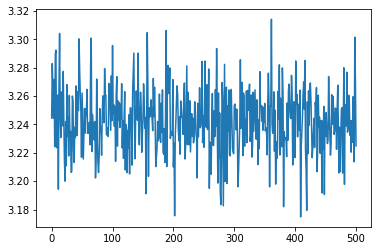

In [269]:
igc_cop = IGC(hidden_size=100, layers_number=2, output_size=64)

u_obs = X_train_cop

optimizer = torch.optim.Adam(igc_cop.parameters())
loss_hist = []

for i in tqdm(range(501)):
    optimizer.zero_grad()
    u = igc_cop.forward_train(torch.randn((200, igc_cop.dim_latent)))
    loss = igc_cop.Energy_Score_pytorch(1, u_obs[np.random.choice(range(u_obs.shape[0]),100,replace=True)], u)
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

plt.plot(loss_hist)

In [270]:
samples_cdf = igc_cop.forward(500).detach().numpy()


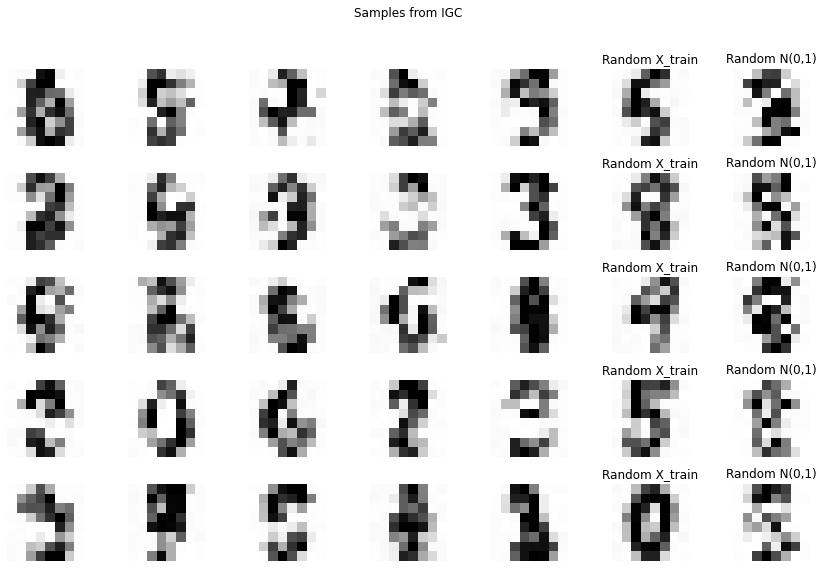

In [271]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create a figure and a set of subplots
fig, axes = plt.subplots(5, 7, figsize=(12, 8))
fig.suptitle('Samples from IGC')

# Loop through each row
for row in range(5):
    # Plot the samples in the first 5 columns
    for col in range(5):
        ax = axes[row, col]
        index = row * 5 + col
        img = reverse_transform(torch.tensor(scs.norm.ppf(samples_cdf[index])).reshape(8, 8)).reshape(8, 8)
        ax.imshow(img, cmap='gray_r')
        ax.axis('off')
        #ax.set_title(f"log_pdf: {log_pdf[index]:.2f}")

    # Plot random samples of X_train in the 6th column
    ax = axes[row, 5]
    random_index = np.random.randint(len(X_train))
    img = reverse_transform(X_train[random_index]).reshape(8, 8)
    ax.imshow(img, cmap='gray_r')
    ax.axis('off')
    ax.set_title("Random X_train")

    # Plot random samples of N(0,1) in the 7th column
    ax = axes[row, 6]
    img = reverse_transform(torch.randn(1, 1, 8, 8)).reshape(8, 8)
    ax.imshow(img, cmap='gray_r')
    ax.axis('off')
    ax.set_title("Random N(0,1)")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make room for the suptitle
plt.show()

In [28]:
def Energy_Score_pytorch(beta, observations_y, simulations_Y):
    m = len(simulations_Y)

    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
            simulations_Y.unsqueeze(0)).float(),
            dim=2,keepdim=True).reshape(-1,1),
        beta)

    # Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy
import ot

def W2(x,y):
    return torch.sqrt(ot.emd2(torch.ones(x.shape[0])/x.shape[0], torch.ones(y.shape[0])/y.shape[0], ot.dist(x, y)))

c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


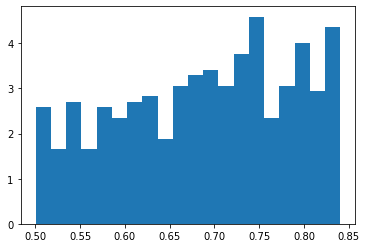

In [35]:
plt.hist(scs.norm.cdf(samples_cdf[:,0]),density=True, bins=20)
plt.show()

In [99]:
# Transform data to unit scale
def to_unit_scale(data):
    unit_data = scs.norm.cdf(data)
    unit_data = np.clip(unit_data, 1e-3, 1 - 1e-3)
    return unit_data

def check_bad_values(data_):
    # Check for NaN, inf or neginf values
    num_nan = np.isnan(data_).sum()
    num_pos_inf = np.isposinf(data_).sum()
    num_neg_inf = np.isneginf(data_).sum()
    if num_nan > 0 or num_pos_inf > 0 or num_neg_inf > 0:
        print(f"!!!!!!! Found {num_nan} NaN, {num_pos_inf} +Inf, and {num_neg_inf} -Inf values.")

# Transform data back to data scale using ECDF
def to_data_scale(data, ecdf_list):
    data_scale = np.zeros_like(data)
    for dim in range(data.shape[1]):
        data_scale[:, dim] = np.interp(data[:, dim], np.linspace(0, 1, len(ecdf_list[dim].x)), ecdf_list[dim].x)
    data_scale = scs.norm.ppf(data_scale)
    check_bad_values(data_scale)
    return data_scale

# Transform samples
print('samples hmc simple')
samples_unit_simple = to_unit_scale(samples_simple)
samples_data_simple = to_data_scale(samples_unit_simple, ecdf_list)

print('samples hmc')
samples_unit = to_unit_scale(samples)
samples_data = to_data_scale(samples_unit, ecdf_list)

print('IGC samples')
IGC_unit = np.clip(samples_cdf, 1e-3, 1 - 1e-3)
IGC_data = to_data_scale(IGC_unit, ecdf_list)
IGC_gaussian = torch.tensor(scs.norm.ppf(IGC_unit))
print('vine')
vine_unit = to_unit_scale(scs.norm.ppf(cop_sample))
vine_data = to_data_scale(vine_unit, ecdf_list)

print('random')
random_unit = to_unit_scale(torch.randn(500, 64).numpy())
random_data = to_data_scale(random_unit, ecdf_list)
print('GG')
GG_cov = np.cov(X_train.reshape(-1,64).T)
GG_samples = scs.multivariate_normal.rvs(mean=np.zeros(64), cov=GG_cov, size=500)
GG_samples_unit = to_unit_scale(GG_samples)
GG_samples_data = to_data_scale(GG_samples_unit, ecdf_list)
print('observations')
X_train_unit = to_unit_scale(X_train.reshape(-1, 64))
X_train_data = to_data_scale(X_train_unit, ecdf_list)
print('test')
X_test_unit = to_unit_scale(X_test.reshape(-1, 64))
X_test_data = torch.tensor(to_data_scale(X_test_unit, ecdf_list))

# Compute Energy Score 
print('data scale')
print('Energy Score')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(samples_data_simple).float()), 'samples_hmc_simple')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(samples_data).float()), 'samples_hmc')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(IGC_data).float()), 'IGC')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(vine_data).float()), 'vine')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(random_data).float()), 'random')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(GG_samples_data).float()), 'GG')
print(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(X_train_data).float()), 'observations')

# Compute Wasserstein 2
print('Wasserstein 2')
print(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(samples_data_simple).float()), 'samples_hmc_simple')
print(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(samples_data).float()), 'ratio samples_hmc')
print(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(IGC_data).float()), 'IGC')
print(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(vine_data).float()), 'vine')
print(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(random_data).float()), 'random')
print(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(GG_samples_data).float()), 'GG')
print(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(X_train_data).float()), 'observations')


#### Energy Score
print('Gaussian scale')
print('Energy Score')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples_simple).float()),'samples_hmc')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples_hmc')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),IGC_gaussian.float()),'IGC')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(500,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

#### Wasserstein 2
print('Wasserstein 2')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples_simple).float()),'samples_hmc')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(samples).float()),'ratio samples_hmc')
print(W2(X_test.reshape(-1,64).float(),IGC_gaussian.float(),),'IGC')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(scs.norm.ppf(cop_sample)).float()),'vine')
print(W2(X_test.reshape(-1,64).float(),torch.randn(500,64).float()),'random')
print(W2(X_test.reshape(-1,64).float(),torch.tensor(GG_samples).float()),'GG')
print(W2(X_test.reshape(-1,64).float(),X_train.reshape(-1,64).float()),'observations')


samples hmc simple
samples hmc
IGC samples
vine
random
GG
observations
test
data scale
Energy Score
tensor(10.9078) samples_hmc_simple
tensor(10.9109) samples_hmc
tensor(10.8406) IGC
tensor(10.8514) vine
tensor(10.9166) random
tensor(10.8517) GG
tensor(10.8214) observations
Wasserstein 2
tensor(6.9640) samples_hmc_simple
tensor(7.1044) ratio samples_hmc
tensor(6.6789) IGC
tensor(7.5321) vine
tensor(8.5273) random
tensor(7.0491) GG
tensor(4.7719) observations
Gaussian scale
Energy Score
tensor(11.3583) samples_hmc
tensor(11.2952) samples_hmc
tensor(11.2377) IGC
tensor(11.2241) vine
tensor(11.2503) random
tensor(11.2381) GG
tensor(11.2252) observations
Wasserstein 2
tensor(8.6447) samples_hmc
tensor(8.2845) ratio samples_hmc
tensor(8.0720) IGC
tensor(8.5735) vine
tensor(9.1770) random
tensor(8.3131) GG
tensor(7.4011) observations


In [291]:
# Transform data to unit scale
def to_unit_scale(data):
    unit_data = scs.norm.cdf(data)
    unit_data = np.clip(unit_data, 1e-3, 1 - 1e-3)
    return unit_data

def check_bad_values(data_):
    # Check for NaN, inf or neginf values
    num_nan = np.isnan(data_).sum()
    num_pos_inf = np.isposinf(data_).sum()
    num_neg_inf = np.isneginf(data_).sum()
    if num_nan > 0 or num_pos_inf > 0 or num_neg_inf > 0:
        print(f"!!!!!!! Found {num_nan} NaN, {num_pos_inf} +Inf, and {num_neg_inf} -Inf values.")

# Transform data back to data scale using ECDF
def to_data_scale(data, ecdf_list):
    data_scale = np.zeros_like(data)
    for dim in range(data.shape[1]):
        data_scale[:, dim] = np.interp(data[:, dim], np.linspace(0, 1, len(ecdf_list[dim].x)), ecdf_list[dim].x)
    data_scale = scs.norm.ppf(data_scale)
    check_bad_values(data_scale)
    return data_scale

# Transform samples
print('samples hmc simple')
samples_unit_simple = to_unit_scale(samples_simple)
samples_data_simple = to_data_scale(samples_unit_simple, ecdf_list)

print('samples hmc')
samples_unit = to_unit_scale(samples)
samples_data = to_data_scale(samples_unit, ecdf_list)

print('IGC samples')
IGC_unit = np.clip(samples_cdf, 1e-3, 1 - 1e-3)
IGC_data = to_data_scale(IGC_unit, ecdf_list)
IGC_gaussian = torch.tensor(scs.norm.ppf(IGC_unit))

print('vine')
vine_unit = to_unit_scale(scs.norm.ppf(cop_sample))
vine_data = to_data_scale(vine_unit, ecdf_list)

print('random')
random_unit = to_unit_scale(torch.randn(500, 64).numpy())
random_data = to_data_scale(random_unit, ecdf_list)

print('GG')
GG_cov = np.cov(X_train.reshape(-1, 64).T)
GG_samples = scs.multivariate_normal.rvs(mean=np.zeros(64), cov=GG_cov, size=500)
GG_samples_unit = to_unit_scale(GG_samples)
GG_samples_data = to_data_scale(GG_samples_unit, ecdf_list)

print('observations')
X_train_unit = to_unit_scale(X_train.reshape(-1, 64))
X_train_data = to_data_scale(X_train_unit, ecdf_list)

print('test')
X_test_unit = to_unit_scale(X_test.reshape(-1, 64))
X_test_data = torch.tensor(to_data_scale(X_test_unit, ecdf_list))

# Compute Energy Score 
Energy_data = []
print('data scale')
Energy_data.append(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(samples_data_simple).float()))
Energy_data.append(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(samples_data).float()))
Energy_data.append(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(IGC_data).float()))
Energy_data.append(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(vine_data).float()))
Energy_data.append(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(random_data).float()))
Energy_data.append(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(GG_samples_data).float()))
Energy_data.append(Energy_Score_pytorch(1, X_test_data.reshape(-1, 64), torch.tensor(X_train_data).float()))
print('Energy Score', Energy_data)

# Compute Wasserstein 2
Wasserstein_data = []
Wasserstein_data.append(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(samples_data_simple).float()))
Wasserstein_data.append(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(samples_data).float()))
Wasserstein_data.append(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(IGC_data).float()))
Wasserstein_data.append(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(vine_data).float()))
Wasserstein_data.append(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(random_data).float()))
Wasserstein_data.append(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(GG_samples_data).float()))
Wasserstein_data.append(W2(X_test_data.reshape(-1, 64).float(), torch.tensor(X_train_data).float()))
print('Wasserstein 2', Wasserstein_data)

#### Energy Score
Energy_gaussian = []
print('Gaussian scale')
Energy_gaussian.append(Energy_Score_pytorch(1, X_test.reshape(-1, 64), torch.tensor(samples_simple).float()))
Energy_gaussian.append(Energy_Score_pytorch(1, X_test.reshape(-1, 64), torch.tensor(samples).float()))
Energy_gaussian.append(Energy_Score_pytorch(1, X_test.reshape(-1, 64), IGC_gaussian.float()))
Energy_gaussian.append(Energy_Score_pytorch(1, X_test.reshape(-1, 64), torch.tensor(scs.norm.ppf(cop_sample)).float()))
Energy_gaussian.append(Energy_Score_pytorch(1, X_test.reshape(-1, 64), torch.randn(500, 64).float()))
Energy_gaussian.append(Energy_Score_pytorch(1, X_test.reshape(-1, 64), torch.tensor(GG_samples).float()))
Energy_gaussian.append(Energy_Score_pytorch(1, X_test.reshape(-1, 64), X_train.reshape(-1, 64)))
print('Energy Score', Energy_gaussian)

#### Wasserstein 2
Wasserstein_gaussian = []
Wasserstein_gaussian.append(W2(X_test.reshape(-1, 64).float(), torch.tensor(samples_simple).float()))
Wasserstein_gaussian.append(W2(X_test.reshape(-1, 64).float(), torch.tensor(samples).float()))
Wasserstein_gaussian.append(W2(X_test.reshape(-1, 64).float(), IGC_gaussian.float()))
Wasserstein_gaussian.append(W2(X_test.reshape(-1, 64).float(), torch.tensor(scs.norm.ppf(cop_sample)).float()))
Wasserstein_gaussian.append(W2(X_test.reshape(-1, 64).float(), torch.randn(500, 64).float()))
Wasserstein_gaussian.append(W2(X_test.reshape(-1, 64).float(), torch.tensor(GG_samples).float()))
Wasserstein_gaussian.append(W2(X_test.reshape(-1, 64).float(), X_train.reshape(-1, 64).float()))
print('Wasserstein 2', Wasserstein_gaussian)


samples hmc simple
samples hmc
IGC samples
vine
random
GG
observations
test
data scale
Energy Score [tensor(11.0016), tensor(10.9109), tensor(10.8379), tensor(10.8514), tensor(10.9114), tensor(10.8457), tensor(10.8214)]
Wasserstein 2 [tensor(6.5246), tensor(7.1044), tensor(6.7563), tensor(7.5321), tensor(8.5355), tensor(7.0323), tensor(4.7719)]
Gaussian scale
Energy Score [tensor(11.3636), tensor(11.2952), tensor(11.2300), tensor(11.2241), tensor(11.2534), tensor(11.2271), tensor(11.2252)]
Wasserstein 2 [tensor(8.0461), tensor(8.2845), tensor(8.1308), tensor(8.5735), tensor(9.2036), tensor(8.3058), tensor(7.4011)]


C:\Users\david\AppData\Local\Temp\ipykernel_544\2753090525.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45, ha='right')
C:\Users\david\AppData\Local\Temp\ipykernel_544\2753090525.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45, ha='right')


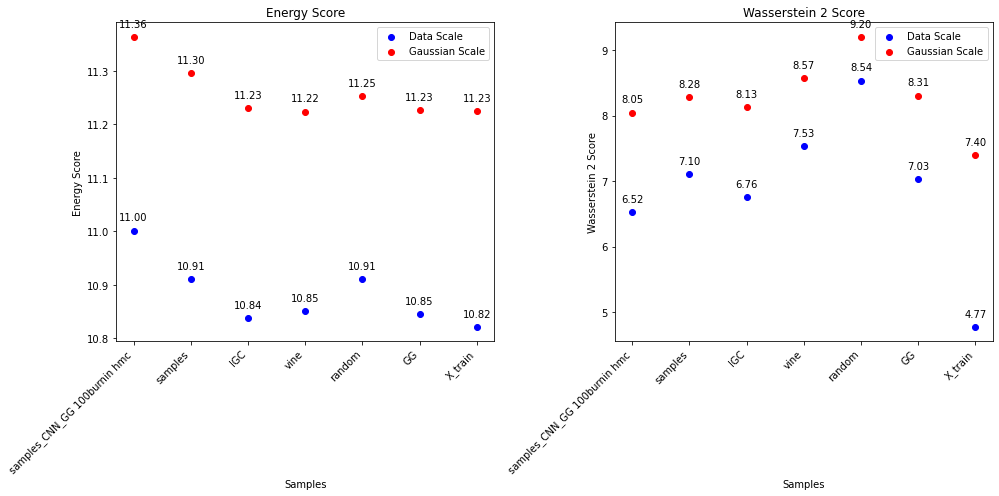

In [292]:
# Labels for the points
labels = ['samples_CNN_GG 100burnin hmc', 'samples', 'IGC', 'vine', 'random', 'GG', 'X_train']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Scatter plot for Energy Score
ax1.scatter(labels, Energy_data, color='blue', label='Data Scale')
ax1.scatter(labels, Energy_gaussian, color='red', label='Gaussian Scale')
for i, txt in enumerate(Energy_data):
    ax1.annotate(f'{txt:.2f}', (labels[i], Energy_data[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(Energy_gaussian):
    ax1.annotate(f'{txt:.2f}', (labels[i], Energy_gaussian[i]), textcoords="offset points", xytext=(0,10), ha='center')
ax1.set_title('Energy Score')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Energy Score')
ax1.legend()
ax1.set_xticklabels(labels, rotation=45, ha='right')

# Scatter plot for Wasserstein 2 Score
ax2.scatter(labels, Wasserstein_data, color='blue', label='Data Scale')
ax2.scatter(labels, Wasserstein_gaussian, color='red', label='Gaussian Scale')
for i, txt in enumerate(Wasserstein_data):
    ax2.annotate(f'{txt:.2f}', (labels[i], Wasserstein_data[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(Wasserstein_gaussian):
    ax2.annotate(f'{txt:.2f}', (labels[i], Wasserstein_gaussian[i]), textcoords="offset points", xytext=(0,10), ha='center')
ax2.set_title('Wasserstein 2 Score')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Wasserstein 2 Score')
ax2.legend()
ax2.set_xticklabels(labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()